In [1]:
import torch
from transformers import AutoTokenizer
from data_utils import NewsDataset

from torch.utils.data import DataLoader

import argparse

from model import Transformer, CustomBertForClassification

from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

/home/valeriy/python_envs/news_category_classification/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from inference import predict, load_model, load_tokenizer, index_to_category

In [3]:
train_batch_size=32
eval_batch_size = 100
accumulation_steps = 150

train_test_split = [0.8, 0.2]
val_test_split = [0.5, 0.5]
epochs = 100
device='cuda'

model_path='weights_final_81_acc.pt'

In [ ]:
if device == 'cuda':
    assert torch.cuda.is_available()

tokenizer = load_tokenizer()
model = load_model(model_path, tokenizer).to(device)


from torch.utils.data import DataLoader
ds = NewsDataset('data.json')

generator = torch.Generator().manual_seed(42)
train_data, test_data = torch.utils.data.random_split(ds, train_test_split,generator=generator)
val_data, test_data = torch.utils.data.random_split(test_data, val_test_split,generator=generator)

dataloader = DataLoader(test_data, batch_size=eval_batch_size,
                        shuffle=False, num_workers=0)


preds = predict(model, tokenizer, dataloader, device)#15m

categorical_preds  = [index_to_category[idx] for idx in preds]
print(categorical_preds)

In [14]:
import pandas as pd
pd.Series(categorical_preds).to_csv('predictions.csv')

In [30]:
categorical_preds = pd.read_csv('predictions.csv')
categorical_preds = list(categorical_preds['0'])

In [32]:
import numpy as np
labels = []
for v in dataloader:
    labels.append(v['y'])

labels = np.concatenate(labels)
labels = [index_to_category[idx] for idx in labels]

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:

cm_original = confusion_matrix(labels, categorical_preds)

In [35]:

cm_norm = confusion_matrix(labels, categorical_preds, normalize='true')

Normalized by rows (true)
true MEDIA prediction POLITICS
true ARTS prediction ENTERTAINMENT
true U.S. NEWS prediction POLITICS
true FIFTY prediction HEALTHY LIVING
true WORLDPOST prediction POLITICS


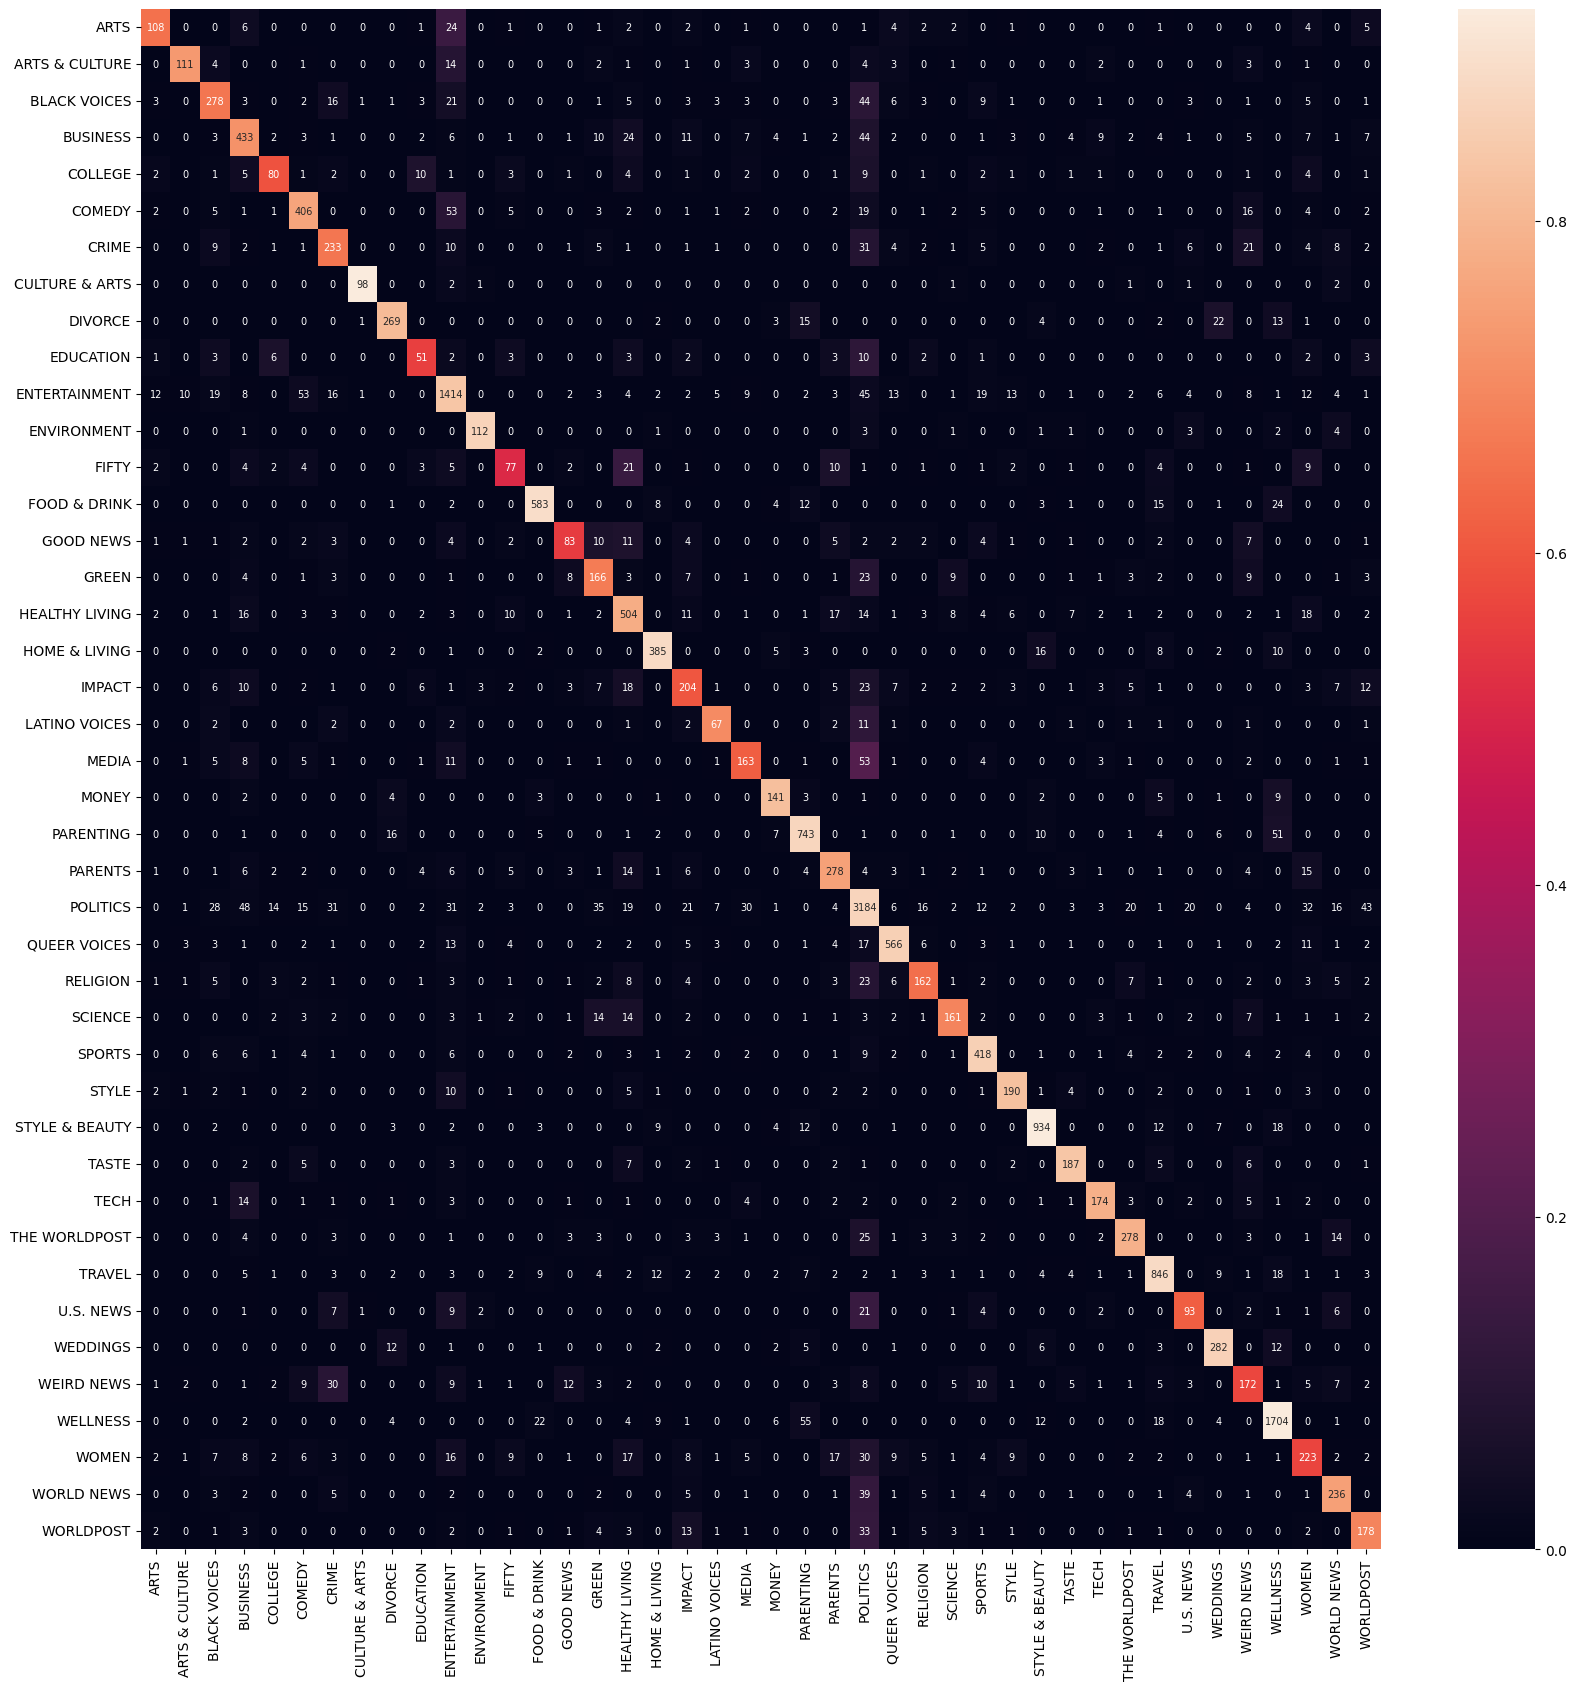

In [102]:
top_k = 5
fig, ax = plt.subplots(figsize=(20,20))
cm_norm_true = confusion_matrix(labels, categorical_preds, normalize='true')
sns.heatmap(cm_norm_true,
            ax=ax,
            annot=cm_original,
            fmt='d',
            annot_kws={"size": 7},
            xticklabels=np.unique(np.array(labels)),
            yticklabels=np.unique(np.array(labels)))

np.fill_diagonal(cm_norm_true,0)

idxs_flat = np.unravel_index( [ cm_norm_true.flatten().argsort()[::-1][:top_k] ], cm_norm_true.shape)
matrix_idxs = list(zip(idxs_flat[0][0], idxs_flat[1][0]))
print('Normalized by rows (true)')
for el in matrix_idxs:
    print('true', index_to_category[el[0]], 'prediction', index_to_category[el[1]] )



Normalized by columns (pred)
true: POLITICS prediction WORLDPOST
true: POLITICS prediction U.S. NEWS
true: POLITICS prediction MEDIA
true: POLITICS prediction GREEN
true: POLITICS prediction COLLEGE


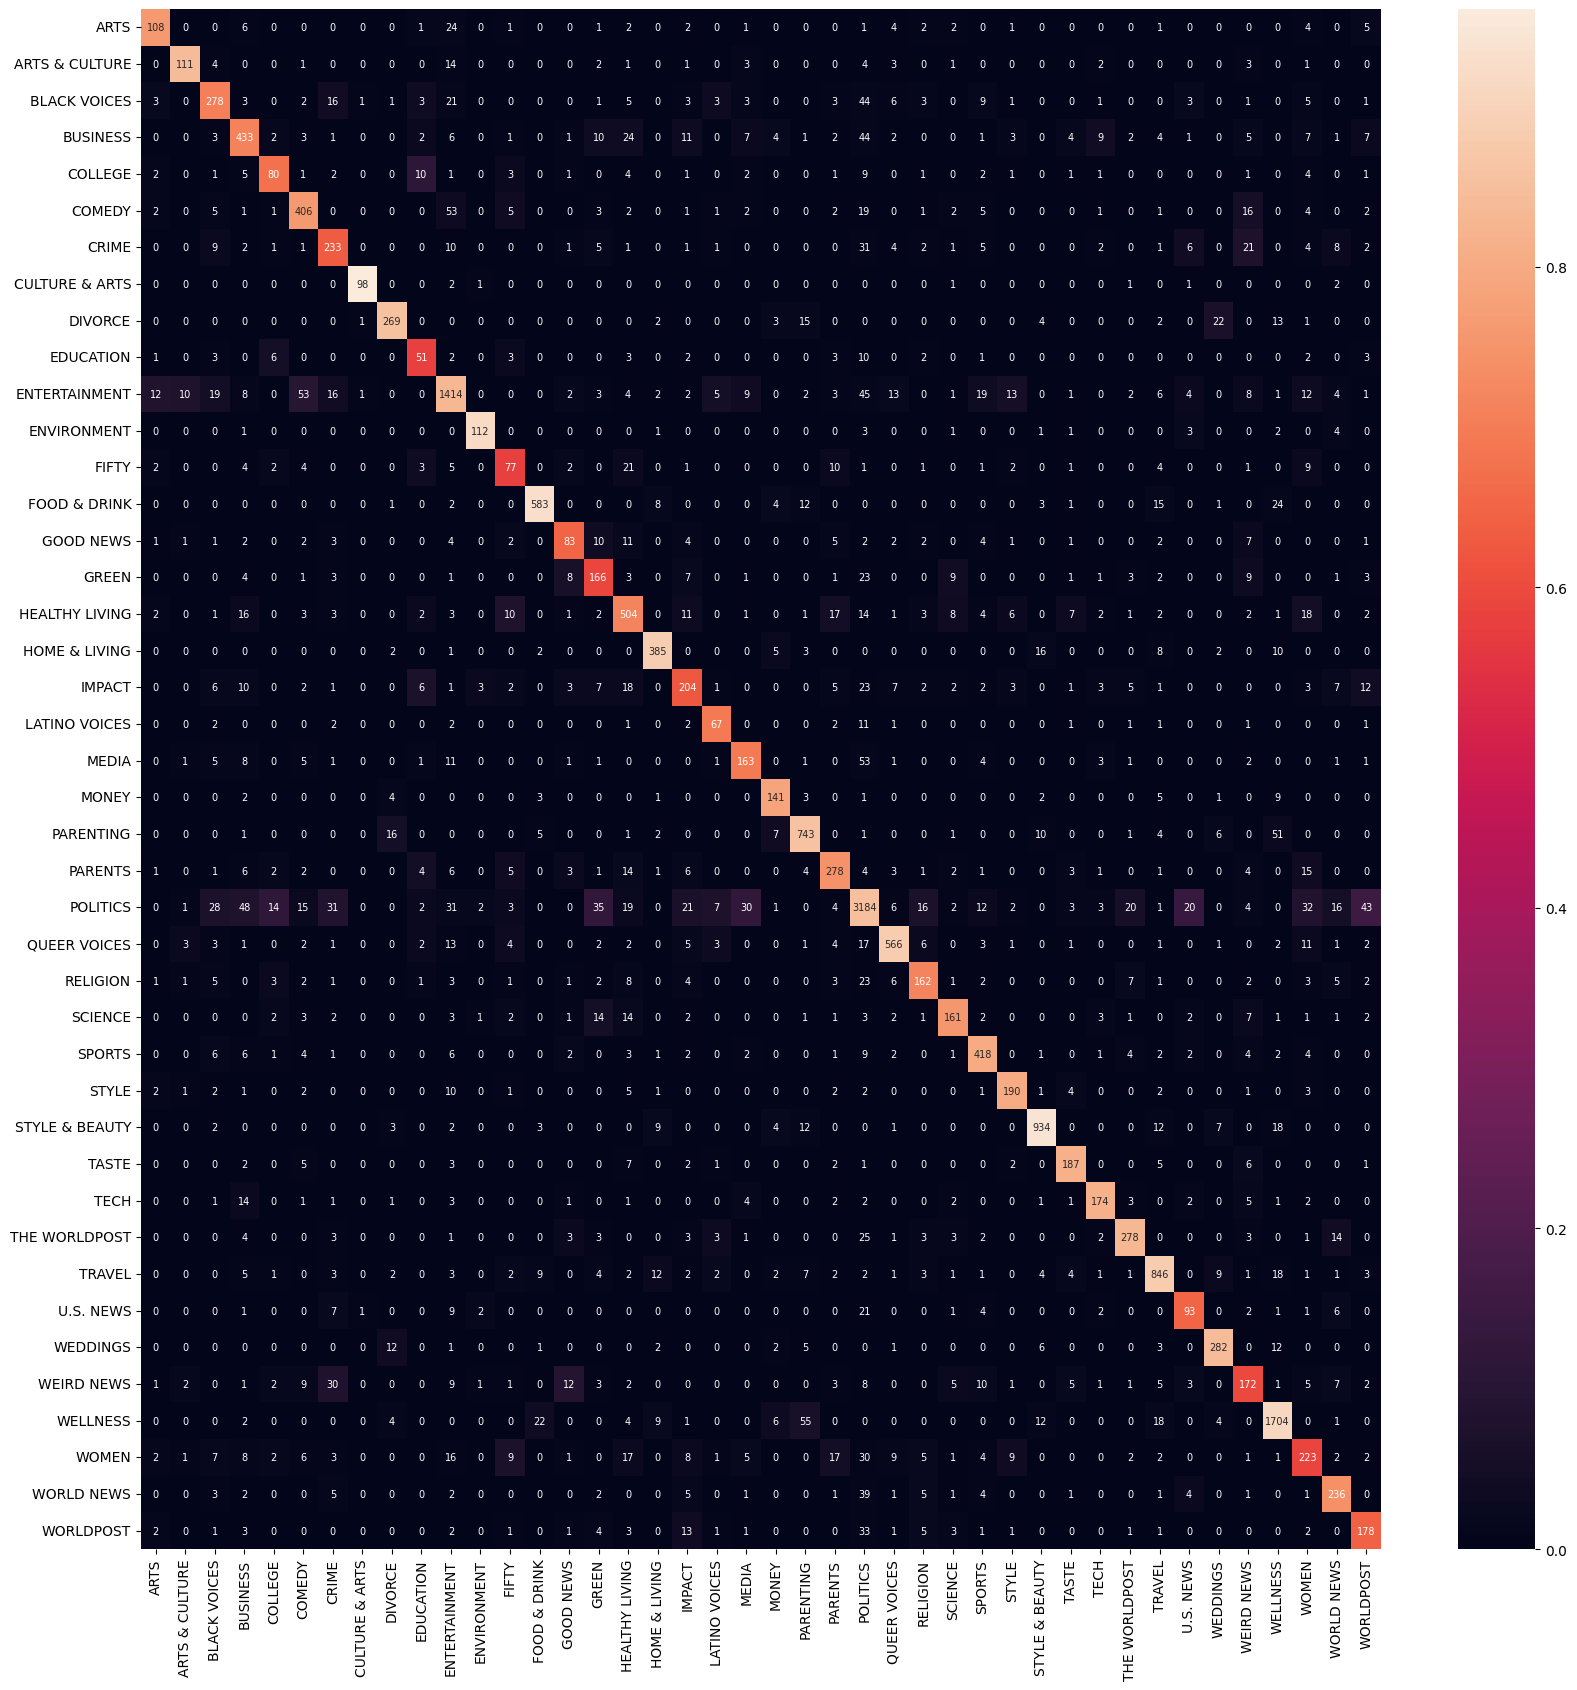

In [103]:
fig, ax = plt.subplots(figsize=(20,20))
cm_norm_pred = confusion_matrix(labels, categorical_preds, normalize='pred')
sns.heatmap(cm_norm_pred,
            ax=ax,
            annot=cm_original,
            fmt='d',
            annot_kws={"size": 7},
            xticklabels=np.unique(np.array(labels)),
            yticklabels=np.unique(np.array(labels)))

np.fill_diagonal(cm_norm_pred,0)


idxs_flat = np.unravel_index( [ cm_norm_pred.flatten().argsort()[::-1][:top_k] ], cm_norm_pred.shape)
matrix_idxs = list(zip(idxs_flat[0][0], idxs_flat[1][0]))
print('Normalized by columns (pred)')
for el in matrix_idxs:
    print('true:', index_to_category[el[0]],'prediction', index_to_category[el[1]] )

From the plots and text ouputs above we can see the most common normalized by:
- Total number of true elements for this category
- Total number of predicted elements for category

In [104]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

In [105]:
print('f1', f1_score(labels, categorical_preds, average='macro'))
print('recall_score', recall_score(labels, categorical_preds, average='macro'))
print('precision_score', precision_score(labels, categorical_preds, average='macro'))
#print('roc_auc_score', roc_auc_score(labels, categorical_preds, average='macro'))

f1 0.7538438245430458
recall_score 0.7471816125380796
precision_score 0.7621414447651548


In [106]:


f1_scores = f1_score(labels, categorical_preds, average=None)
precision_scores = precision_score(labels, categorical_preds, average=None)
recall_scores = recall_score(labels, categorical_preds, average=None)



In [120]:
from collections import Counter
c = Counter(categorical_preds)
df_acc = pd.DataFrame({'category':c.keys(), 'occurence': c.values()})

In [121]:
df = pd.DataFrame({'f1':f1_scores,'precision':precision_scores, 'recall':recall_scores})

In [122]:

df['category'] = [index_to_category[idx] for idx in range(len(df))]

In [123]:
df.sort_values(by='f1', ascending=False).merge(df_acc)

,f1,precision,recall,category,occurence
0,0.942308,0.960784,0.924528,CULTURE & ARTS,102
1,0.933067,0.938693,0.927507,STYLE & BEAUTY,995
2,0.917609,0.910256,0.925081,WELLNESS,1872
3,0.909516,0.928344,0.891437,FOOD & DRINK,628
4,0.892430,0.918033,0.868217,ENVIRONMENT,122
5,0.885057,0.883028,0.887097,HOME & LIVING,436
6,0.883551,0.881250,0.885864,TRAVEL,960
7,0.869432,0.878882,0.860182,QUEER VOICES,644
8,0.866472,0.857968,0.875147,PARENTING,866
9,0.860773,0.850882,0.870897,POLITICS,3742
